In [1]:
import itertools
import numpy as np
from utils import *
from numpy.linalg import *
from scipy.linalg import *
from functools import reduce
from math import log, factorial
from collections import defaultdict
from mindquantum.io.display import BlochScene

np.set_printoptions(linewidth=1000)

In [2]:
def q(ket: str, dim: int = 2):
    return np.eye(dim**len(ket), dtype=CDTYPE)[int(ket, dim)]


GHZ = q('000') + q('111')
GHZ /= norm(GHZ)
str_ket(GHZ)

√2/2¦000⟩
√2/2¦111⟩
[0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


In [3]:
def num_qudits(state: np.ndarray, dim: int = 2) -> int:
    if state.ndim == 2 and (state.shape[0] == 1 or state.shape[1] == 1):
        state = state.flatten()
    if state.ndim == 2 and state.shape[0] != state.shape[1]:
        raise ValueError(f'Wrong state shape {state.shape}')
    if state.ndim != 1 and state.ndim != 2:
        raise ValueError(f'Wrong state shape {state.shape}')
    if not isinstance(dim, (int, np.int64)):
        raise ValueError(f'Wrong dimension type {dim} {type(dim)}')
    n = state.shape[0]
    nq = round(log(n, dim), 12)
    if nq % 1 != 0:
        raise ValueError(f'Wrong state size {n} is not a power of {dim}')
    return int(nq)


def state_site(state: np.ndarray, dim: int = 2, site: int = 0) -> dict:
    if not isinstance(dim, (int, np.int64)):
        raise ValueError(f'Wrong dimension type {dim} {type(dim)}')
    if not isinstance(site, (int, np.int64)):
        raise ValueError(f'Wrong dimension type {site} {type(site)}')
    nq = num_qudits(state, dim)
    if site < 0 or site > nq:
        raise ValueError(f'Wrong site index {site} is not in 0 to {nq}')
    ind = defaultdict(list)
    for i in range(dim**nq):
        base = np.base_repr(i, dim).zfill(nq)
        ind[int(base[site])].append(i)
    state_site = np.array([sum(state[ind[i]]) for i in range(dim)])
    state_site /= norm(state_site)
    return state_site


dim, n_qudits, site = 3, 2, 0
np.random.seed(42)
qudit = np.random.rand(dim**n_qudits) + 1j * np.random.rand(dim**n_qudits)
str_ket(qudit, dim)
qudit = state_site(qudit, dim, site)
str_ket(qudit, dim)
qubit = symmetric_encoding(qudit)
str_ket(qubit)

0.3745+0.7081j¦00⟩
0.9507+0.0206j¦01⟩
0.732+0.9699j¦02⟩
0.5987+0.8324j¦10⟩
0.156+0.2123j¦11⟩
0.156+0.1818j¦12⟩
0.0581+0.1834j¦20⟩
0.8662+0.3042j¦21⟩
0.6011+0.5248j¦22⟩
[0.37454012+0.70807258j 0.95071431+0.02058449j 0.73199394+0.96990985j 0.59865848+0.83244264j 0.15601864+0.21233911j 0.15599452+0.18182497j 0.05808361+0.18340451j 0.86617615+0.30424224j 0.60111501+0.52475643j]
0.575+0.4747j¦0⟩
0.2545+0.3428j¦1⟩
0.4263+0.2829j¦2⟩
[0.57495067+0.47470797j 0.25451048+0.34280662j 0.42630499+0.28294196j]
0.575+0.4747j¦00⟩
0.18+0.2424j¦01⟩
0.18+0.2424j¦10⟩
0.4263+0.2829j¦11⟩
[0.57495067+0.47470797j 0.17996609+0.24240089j 0.17996609+0.24240089j 0.42630499+0.28294196j]


In [4]:
def Majorana_representation(qubit: np.ndarray) -> list:
    return qubit


Majorana_representation(qubit)

array([0.57495067+0.47470797j, 0.17996609+0.24240089j, 0.17996609+0.24240089j, 0.42630499+0.28294196j])

In [5]:
def Majorana_points(points: list) -> np.ndarray:
    nq_list = [num_qudits(i) for i in points]
    if len(set(nq_list)) != 1 or nq_list[0] != 1:
        raise ValueError(f'Wrong number of qubits {nq_list} is not 1')
    num = len(points)
    points_list, K_list = [], []
    for ind in itertools.permutations(range(num)):
        points_perm = [points[i] for i in ind]
        points_list.append(reduce(np.kron, points_perm))
        K_perm = 1
        for i, j in enumerate(ind):
            K_perm *= np.inner(points[i].conj(), points[j])
        K_list.append(K_perm)
    K = factorial(num) * sum(K_list)
    state = sum(points_list) / np.sqrt(K)
    return state


nq = 2
MP_list = []
np.random.seed(42)
for _ in range(4):
    MP = np.random.rand(2) + 1j * np.random.rand(2)
    MP /= norm(MP)
    MP_list.append(MP)
a = q('0') + q('1')
b = q('0') + np.exp(1j * 4 * np.pi / 3) * q('1')
c = q('0') + np.exp(1j * 2 * np.pi / 3) * q('1')
# MP_list = [a, b, c]
sym_state = Majorana_points(MP_list)
str_ket(sym_state)
is_symmetric(sym_state)

-0.0098+0.0734j¦0000⟩
-0.1155+0.0852j¦0001⟩
-0.1155+0.0852j¦0010⟩
-0.2129+√5/53j¦0011⟩
-0.1155+0.0852j¦0100⟩
-0.2129+√5/53j¦0101⟩
-0.2129+√5/53j¦0110⟩
-0.3552-0.0179j¦0111⟩
-0.1155+0.0852j¦1000⟩
-0.2129+√5/53j¦1001⟩
-0.2129+√5/53j¦1010⟩
-0.3552-0.0179j¦1011⟩
-0.2129+√5/53j¦1100⟩
-0.3552-0.0179j¦1101⟩
-0.3552-0.0179j¦1110⟩
-0.3141-0.1578j¦1111⟩
[-0.00979401+0.07335784j -0.11552651+0.08517565j -0.11552651+0.08517565j -0.21292817+0.04219071j -0.11552651+0.08517565j -0.21292817+0.04219071j -0.21292817+0.04219071j -0.3551703 -0.01794872j -0.11552651+0.08517565j -0.21292817+0.04219071j -0.21292817+0.04219071j -0.3551703 -0.01794872j -0.21292817+0.04219071j -0.3551703 -0.01794872j -0.3551703 -0.01794872j -0.31406238-0.1577951j ]


True

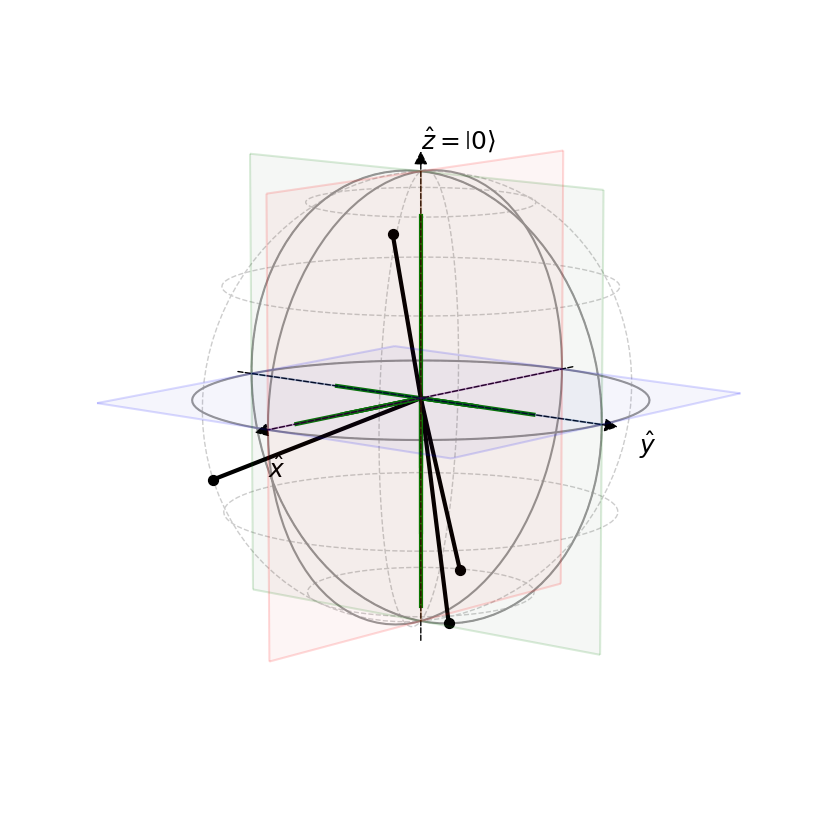

In [6]:
scene = BlochScene()
fig, ax = scene.create_scene()
for MP in MP_list:
    scene.add_state(ax, MP)